In [1]:
import pickle
import os

FOLDER = os.getcwd() + "/10cell_no_noise"

with open(FOLDER+'/ori.pkl', 'rb') as file:   
    ori = pickle.load(file)
with open(FOLDER+'/mask.pkl', 'rb') as file:   
    mask = pickle.load(file)
with open(FOLDER+'/out.pkl', 'rb') as file:   
    out = pickle.load(file)


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.rcParams['figure.figsize'] = [15, 5]
import math
import numpy as np
import random
import time



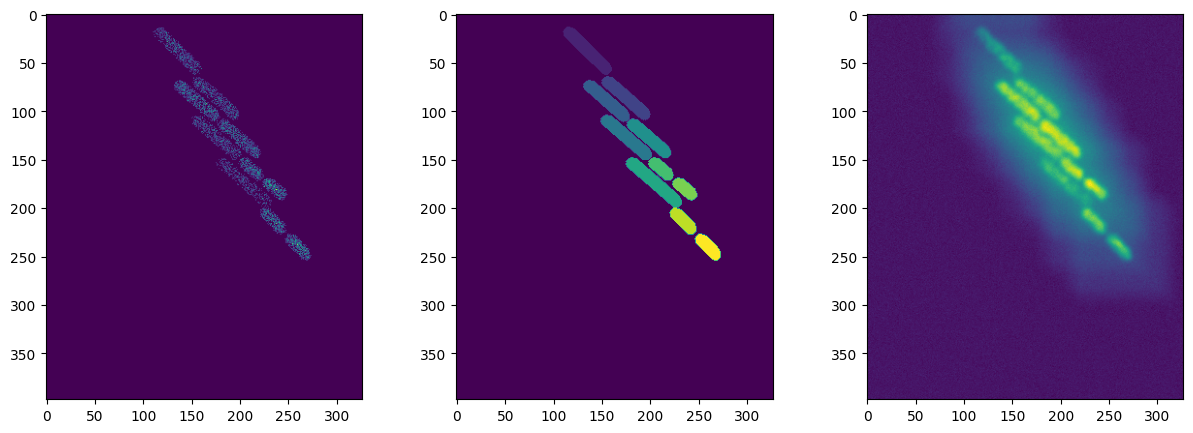

In [3]:
f, axarr = plt.subplots(1,3)
axarr[0].imshow(ori)
axarr[1].imshow(mask)
axarr[2].imshow(out)
plt.show()

6348


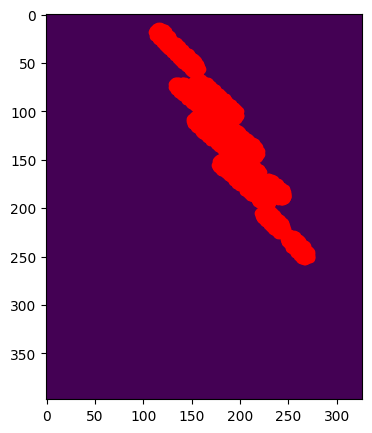

In [4]:
#Final all non zero mask points

sourcePts = []

(maskWidth, maskHeight) = mask.shape

for i in range(maskWidth):
    for j in range(maskHeight):
        if mask[i,j] != 0:
            sourcePts.append([i,j])
print(len(sourcePts))

#Take only a random subset of the sourcePts

random.shuffle(sourcePts)
sourcePts = sourcePts[:]

"""
for k in sourcePts:
    plt.scatter(k[1],k[0],c='r')
plt.imshow(mask)
"""


In [5]:
def AverageFilter(img, x, y):
    sz = [ -3, -2, -1, 0 , 1, 2, 3]
    total = 0
    for i in sz:
        for j in sz:
            total += img[x+i][y+j]
    total/=len(sz)*len(sz)
    return total

outputIntensity = {}
(outputWidth, outputHeight) = out.shape

for pt in sourcePts:
    x = pt[0]
    y = pt[1]
    outputIntensity[(x,y)] = AverageFilter(out,x,y)

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [7]:
def euclideanDistance(x,y):
    return ((x[0]-y[0])**2 + (x[1]-y[1])**2)**0.5

N = len(sourcePts)
distanceMatrix= []
intensityMatrix = []
maskSize = euclideanDistance(mask.shape,(0,0)) 

for idx in range(N):
    current = sourcePts[idx]
    distance = [euclideanDistance(sourcePts[k],current)/maskSize for k in range(N)] #Normalise by diagonal length of mask
    intensty = [AverageFilter(out,current[0],current[1])/65535] #Normalise by max intensity
    distanceMatrix.append(torch.tensor(distance))
    intensityMatrix.append(torch.tensor(intensty))

#Convert to tensor
distanceMatrix = torch.stack(distanceMatrix)
intensityMatrix = torch.stack(intensityMatrix)

In [8]:
#Create custom dataset
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, distanceMatrix, intensityMatrix):
        self.distanceMatrix = distanceMatrix
        self.intensityMatrix = intensityMatrix
    def __len__(self):
        return len(self.intensityMatrix)

    def __getitem__(self, idx):
        return (self.distanceMatrix[idx], self.intensityMatrix[idx]) 
dataset = CustomDataset(distanceMatrix, intensityMatrix)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=8, shuffle=True, num_workers=2)

In [9]:
class Net(nn.Module):
    def __init__(self,N):
        super(Net, self).__init__()
        self.polynomial_degree = 20
        self.polynomial_weights = nn.Linear(self.polynomial_degree,1,bias=False)
        self.polynomial_weights.weight.data[0][0] = -150
        self.actual_intensity = nn.Linear(N,1,bias=False)

    def forward(self, x):
        stack = []
        for i in range (1, self.polynomial_degree+1):
            stack.append(torch.pow(x,2*i))
        x = torch.stack(stack, dim=2)
        x = self.polynomial_weights(x)
        x = x.reshape(x.shape[0],x.shape[1])
        x = torch.exp(x)
        x = self.actual_intensity(x)
        return x

model = Net(N)
model.actual_intensity.weight.data.clamp_(0, 1) #Clamp parameters of last layer
#model.polynomial_weights.bias.data.clamp_(1, 1) #Clamp parameters of const of polynomial

#Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)


In [10]:
#Training loop

EPOCH = 200
timestr = time.strftime("%Y%m%d-%H%M%S")
PATH = FOLDER + "/model-"+timestr+".pt"


for epoch in range(EPOCH):  # loop over the dataset multiple times
    print("Epoch: ",epoch+1)
    running_loss = 0.0
    for i, data in enumerate(dataloader, 0):
        model.zero_grad()
        # get the inputs; data is a list of [inputs, labels]
        inputs, outputs = data
        # forward + backward + optimize
        nn_outputs = model(inputs)
        loss = criterion(nn_outputs.float(), outputs.float())
        loss.backward()
        optimizer.step()
        model.actual_intensity.weight.data.clamp_(0, 1) #Clamp parameters of last layer
        #model.polynomial_weights.bias.data.clamp_(1, 1) #Clamp parameters of const of polynomial
        # print statistics
        running_loss += loss.item()
    print("Loss: ",running_loss)
print('Finished Training')

LOSS = criterion(nn_outputs.float(), outputs.float())

torch.save({
            'epoch': EPOCH,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': LOSS,
            }, PATH)


Epoch:  1
Loss:  351.7532858834602
Epoch:  2
Loss:  340.07257095724344
Epoch:  3
Loss:  319.59631567727774
Epoch:  4
Loss:  315.01832523569465
Epoch:  5
Loss:  279.1787982713431
Epoch:  6
Loss:  287.2458626013249
Epoch:  7
Loss:  368.62898997962475
Epoch:  8
Loss:  304.3668063413352
Epoch:  9
Loss:  331.37158335279673
Epoch:  10
Loss:  321.24304423388094
Epoch:  11
Loss:  325.1856316300109
Epoch:  12
Loss:  270.9451040122658
Epoch:  13
Loss:  336.21889048442245
Epoch:  14
Loss:  315.0105348266661
Epoch:  15
Loss:  307.38295534439385
Epoch:  16
Loss:  332.89738307055086
Epoch:  17
Loss:  336.862974204123
Epoch:  18
Loss:  340.18401971645653
Epoch:  19
Loss:  300.20297510549426
Epoch:  20
Loss:  290.40001821145415
Epoch:  21
Loss:  285.92478904128075
Epoch:  22
Loss:  291.25179447513074
Epoch:  23
Loss:  282.04245042800903
Epoch:  24
Loss:  276.56526625342667
Epoch:  25
Loss:  306.4716440299526
Epoch:  26
Loss:  305.53862319886684
Epoch:  27
Loss:  308.13114202488214
Epoch:  28
Loss:  31

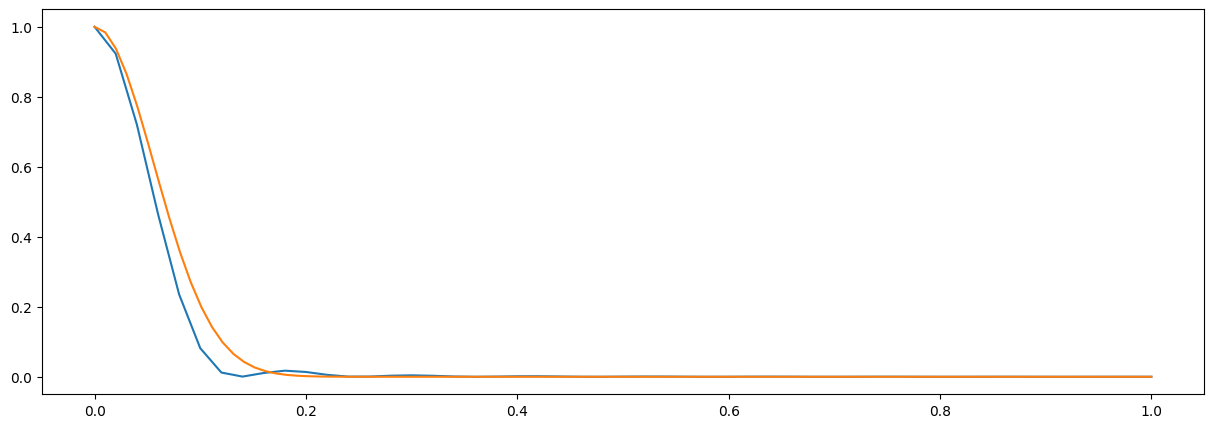

In [11]:
#Checks our model's psf against original psf

with open(FOLDER+'/psf.pkl', 'rb') as file:   
    original_psf = pickle.load(file)

#Normalise x axis of original psf to 1
original_psf_x = np.linspace(0,1,len(original_psf))
original_psf_y = original_psf
plt.plot(original_psf_x,original_psf_y)


coeff = model.polynomial_weights.weight.data[0]
bias = 0
                                          
def getPSF(x, coeff, bias):
    total = bias
    for i in range(len(coeff)):
        total += coeff[i]*(x**(2*(i+1)))
    return torch.exp(total)

new_psf_x = np.linspace(0,1,100)
new_psf_y = getPSF(new_psf_x, coeff, bias)
plt.plot(new_psf_x,new_psf_y.detach().numpy())
plt.show()


In [12]:
print(model.actual_intensity.weight.data)

tensor([[0.0000, 0.0001, 0.0000,  ..., 0.0000, 0.0004, 0.0000]])


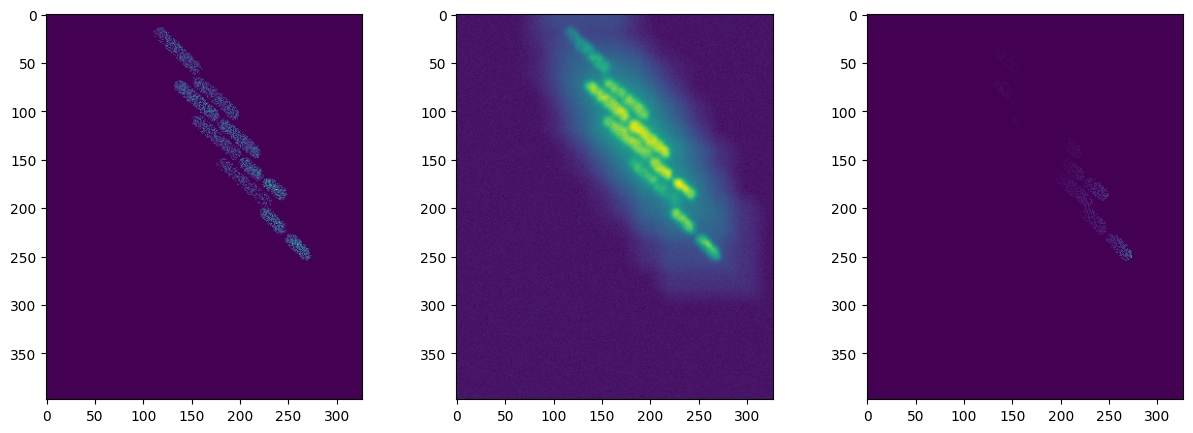

In [13]:
#Recreate original image based off of calculated intensity

customOriginal = np.zeros((maskWidth,maskHeight))
maskToNewIntensity = {}
maskToNewIntensity[0.0] = 0.0
modelIntensity = model.actual_intensity.weight.data[0]
for i in range(len(modelIntensity)):
    customOriginal[sourcePts[i][0]][sourcePts[i][1]] = modelIntensity[i]

oriNormalised = np.asanyarray(ori)
oriNormalised = oriNormalised / max(oriNormalised.flatten())

outNormalised = np.asanyarray(out)
outNormalised = outNormalised / max(outNormalised.flatten())

f, axarr = plt.subplots(1,3)
axarr[0].imshow(oriNormalised)
axarr[1].imshow(outNormalised)
axarr[2].imshow(customOriginal)
plt.show()
